In [1]:
%matplotlib inline

In [2]:
from include.bow import BoW
from include.data import load_data, pad

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

In [3]:
# load data 
# 400 vertical acceleration signals sampled at 50 Hz, showing normal pavement vs. road anomalies 
# 100 examples per category (Normal, Asphalt_bump, Metal_bump, Pothole)
X, tags = load_data()

# make all examples 400 timestamps long, padding with their mean value
X = pad(X, 400, 'mean')

# binarize tags: Normal road vs. Anomaly
binary_tags = list(map(lambda x: x if x=='Normal' else 'Anomaly', tags))

# encode tags with integer numbers
encoder = LabelEncoder()
Y = encoder.fit_transform(binary_tags)

In [4]:
# BoW parameters
K=60 # number of codewords to use
L=10 # length of each segment


In [5]:
scores = {
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1'  :	[],
    'G-means' :	[],
    'AUC' :	[],
}

In [7]:
# k-fold crossvalidation with k=5 (five repetitions with 80%/20% training-testing ratio)
folds = KFold(n_splits=5, shuffle=True).split(X, Y)
for train_indices, test_indices in folds:

    bow = BoW(K=K, size=L )
    bow.fit(X[train_indices]) # create codebook from training signals
    
    # transform signals into histograms
    train = bow.transform(X[train_indices]) 
    test  = bow.transform(X[test_indices])

    # train classifier
    clf = MLPClassifier( 
        hidden_layer_sizes=( int(K/2), ),
        max_iter=2000,
    )
    clf.fit(train, Y[train_indices])

    # make predictions
    predict_classes = clf.predict(test)
    predict_probas  = clf.predict_proba(test)

    # results are evaluated and the calculated metrics are saved
    averaging = 'weighted'
    scores['Accuracy'].append( metrics.accuracy_score(Y[test_indices], predict_classes) )
    scores['Precision'].append( metrics.precision_score(Y[test_indices], predict_classes, average=averaging) )
    scores['Recall'].append( metrics.recall_score(Y[test_indices], predict_classes, average=averaging) )
    scores['F1'].append( metrics.f1_score(Y[test_indices], predict_classes, average=averaging) )
    C = metrics.confusion_matrix(Y[test_indices], predict_classes)
    TP = float(C[0][0])
    FN = float(C[0][1])
    FP = float(C[1][0])
    TN = float(C[1][1])
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    scores['G-means'].append( np.sqrt(sensitivity * specificity) )
    fpr, tpr, thresholds = metrics.roc_curve(Y[test_indices], predict_probas[:, 1])
    scores['AUC'].append( metrics.auc(fpr, tpr) )

In [8]:
# average results in the evaluated metrics
print('Metric', 'Avg.' )
for k in sorted(scores.keys()):
    print(k, np.mean(scores[k]) )

Metric Avg.
AUC 0.97608841092
Accuracy 0.975
F1 0.974624655006
G-means 0.960003985244
Precision 0.975688533478
Recall 0.975


In [9]:
# a randomly chosen signal to visualize BoW representations
x = X[ np.random.randint(0, len(X)) ]

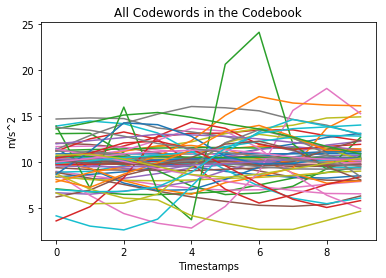

In [13]:
# the codewords found by clustering
codewords = bow.get_codebook()

plt.title('All Codewords in the Codebook')
plt.ylabel('m/s^2')
plt.xlabel('Timestamps')
plt.plot(codewords.T)
plt.show()

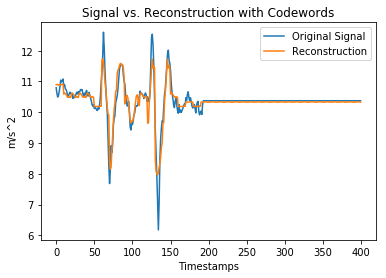

In [14]:
# reconstructing a signal with the codewords
c = bow.to_codewords(x)

plt.title('Signal vs. Reconstruction with Codewords')
plt.ylabel('m/s^2')
plt.xlabel('Timestamps')
plt.plot(x, label='Original Signal')
plt.plot(c, label='Reconstruction')
plt.legend()
plt.show()

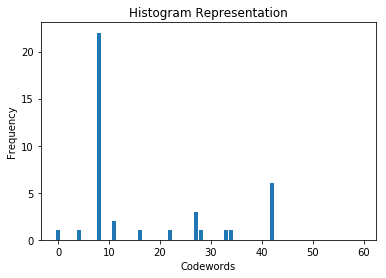

In [12]:
# histogram representation of a signal
h = bow.to_histogram(x)

plt.title('Histogram Representation')
plt.bar(range(0,K), h)
plt.ylabel('Frequency')
plt.xlabel('Codewords')	
plt.show()